[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/dl/blob/master/frameworks/exercise_solution.ipynb)

# Frameworks - exercise (solution)

Using Pytorch, code a Keras-like API to train a sequential model on the MNIST dataset.

In [1]:
import torch
from fastprogress import master_bar, progress_bar

device = "cuda" if torch.cuda.is_available() else "cpu"

class MyModel():
  def __init__(self, net):
    self.net = net

  def compile(self, loss, optimizer, metrics):
    self.loss = loss
    self.optimizer = optimizer
    self.metrics = metrics
    
  def train(self, dataloader):
    self.net.train()
    train_loss, train_metrics = [], [[] for m in self.metrics]
    for X, y in progress_bar(dataloader, parent=self.mb):
        X, y = X.to(device), y.to(device)  
        self.optimizer.zero_grad()
        output = self.net(X)
        loss = self.loss(output, y)
        loss.backward()
        self.optimizer.step()
        train_loss.append(loss.item())
        comment = f'train_loss {np.mean(train_loss):.5f}'
        for i, metric in enumerate(self.metrics):
          train_metrics[i].append(metric(output, y))
          comment += f' train_{metric.name} {np.mean(train_metrics[i]):.5f}'
        self.mb.child.comment = comment
    train_loss, train_metrics = np.mean(train_loss), [np.mean(metric) for metric in train_metrics]
    return train_loss, train_metrics
  
  def eval(self, dataloader):
    self.net.eval()
    val_loss, val_metrics = [], [[] for m in self.metrics]
    with torch.no_grad():
        for X, y in progress_bar(dataloader, parent=self.mb):
          X, y = X.to(device), y.to(device)  
          output = self.net(X)
          loss = self.loss(output, y)
          val_loss.append(loss.item())
          comment = f'val_loss {np.mean(val_loss):.5f}'
          for i, metric in enumerate(self.metrics):
            val_metrics[i].append(metric(output, y))
            comment += f' val_{metric.name} {np.mean(val_metrics[i]):.5f}'
          self.mb.child.comment = comment
        val_loss, val_metrics = np.mean(val_loss), [np.mean(metric) for metric in val_metrics]
        return val_loss, val_metrics

  def fit(self, dataloader, val_dataloader, epochs=100):
    self.net.to(device)
    
    self.history = {"train_loss": [], "val_loss": []}
    for metric in self.metrics:
      self.history[f'train_{metric.name}'] = []
      self.history[f'val_{metric.name}'] = []
      
    self.mb = master_bar(range(1, epochs+1))
    for epoch in self.mb:
      # train
      train_loss, train_metrics = self.train(dataloader)
      # eval
      val_loss, val_metrics = self.eval(val_dataloader)
      # save metrics
      self.history["train_loss"].append(train_loss)
      self.history["val_loss"].append(val_loss)
      for i, metric in enumerate(self.metrics):
        self.history[f'train_{metric.name}'].append(train_metrics[i])
        self.history[f'val_{metric.name}'].append(val_metrics[i])
      # plot bar
      comment = f'Epoch {epoch}/{epochs} train_loss {train_loss:.5f} val_loss {val_loss:.5f}'
      for i, metric in enumerate(self.metrics):
        comment += f' train_{metric.name} {train_metrics[i]:.5f} val_{metric.name} {val_metrics[i]:.5f}'
      self.mb.write(comment)
    
    return self.history

  def predict(self, dataloader):
    self.net.to(device)
    self.net.eval()
    self.mb = master_bar(range(0, 1))
    preds = torch.tensor([])
    for e in self.mb:
        with torch.no_grad():
            for X in progress_bar(dataloader, parent=self.mb):
                X = X.to(device)
                pred = torch.softmax(self.net(X), axis=1)
                preds = torch.cat([preds, pred.cpu()])
    return preds

  def evaluate(self, dataloader):
    self.net.to(device)
    self.mb = master_bar(range(0, 1))
    for e in self.mb:
        val_loss, val_metrics = self.eval(dataloader)
        bar_text = f' val_loss {val_loss:.5f}'
        for i, metric in enumerate(self.metrics):
            bar_text += f' val_{metric.name} {val_metrics[i]:.5f}'
        self.mb.write(bar_text)

In [2]:
class Accuracy():
  def __init__(self):
    self.name = "acc"
  
  def __call__(self, output, labels):
    return (torch.argmax(output, axis=1) == labels).sum().item() / labels.shape[0] 

In [3]:
class MyDataset():
    def __init__(self, images, labels=None, train=True):
        self.train = train
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        img = self.images[ix]
        img = torch.from_numpy(img / 255).float()
        if self.train:
            label = torch.tensor(self.labels[ix]).long()
            return img, label
        return img

The following code should work


In [4]:
# download dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

y = y.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
# define dataloaders

from torch.utils.data import DataLoader

datasets = {
    'train': MyDataset(X_train, y_train),
    'eval': MyDataset(X_eval, y_eval),
    'test': MyDataset(X_test, train=False)
}

bs = 32
dataloaders = {
    'train': DataLoader(datasets['train'], shuffle=True, batch_size=bs),
    'eval': DataLoader(datasets['eval'], shuffle=False, batch_size=bs),
    'test': DataLoader(datasets['test'], shuffle=False, batch_size=bs)
}

In [6]:
# train the network

net = torch.nn.Sequential(
  torch.nn.Linear(28*28, 100),
  torch.nn.ReLU(),
  torch.nn.Linear(100, 10)    
)

model = MyModel(net)

model.compile(loss=torch.nn.CrossEntropyLoss(),
              optimizer=torch.optim.SGD(net.parameters(), lr=0.01),
              metrics=[Accuracy()])

history = model.fit(dataloaders['train'], dataloaders['eval'], epochs=10)

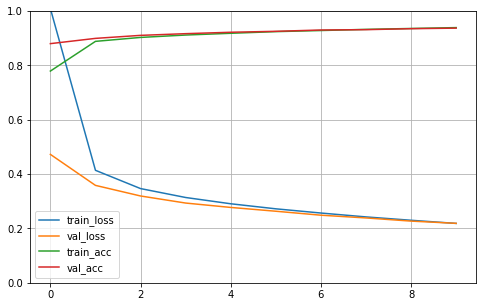

In [7]:
# plot learning curves

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [8]:
# evaluate the model

model.evaluate(dataloaders['eval'])

In [9]:
# get new predictions

y_proba = model.predict(dataloaders['test'])
y_pred = torch.argmax(y_proba, axis=1)

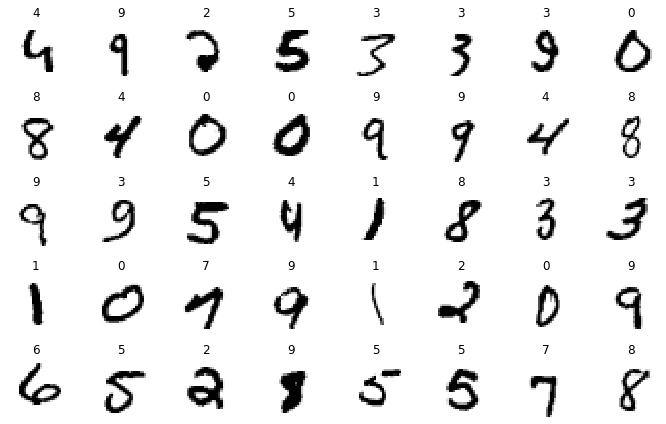

In [10]:
# visualize some new predictions

import random

r, c = 5, 8
plt.figure(figsize=(c*1.2, r*1.2))
for row in range(r):
    for col in range(c):
        plt.subplot(r, c, c*row+col+1)
        ix = random.randint(0, len(datasets['test']))
        img = datasets['test'][ix]
        plt.imshow(img.reshape(28,28), cmap="binary", interpolation="nearest")
        plt.axis('off')
        pred = y_pred[ix].item()
        plt.title(pred, fontsize=12)
plt.tight_layout()
plt.show()